In [52]:
import pandas as pd
from geopy.distance import geodesic
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import spacy

from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
import pysentiment2 as ps

from sklearn.impute import KNNImputer
import re

from stargazer.stargazer import Stargazer


### Download relevant spacy packages if needed

In [53]:
# ! python -m spacy download es_core_news_sm

In [54]:
# load the data
bcn_nonevent = pd.read_csv(r"2024-05-11_2024-05-19_Barcelona.csv", index_col=0)
bcn_event = pd.read_csv(r"2024-05-25_2024-06-02_Barcelona.csv", index_col=0)

val_nonevent = pd.read_csv(r"2024-05-11_2024-05-19_Valencia.csv", index_col=0)
val_event = pd.read_csv(r"2024-05-25_2024-06-02_Valencia.csv", index_col=0)

In [55]:
# load top hotel brands from https://brandirectory.com/rankings/hotels/table
top_hotel_brands = pd.read_csv(r"top_hotel_brands.csv", header=None)
top_hotel_brands.columns = ['name']
top_hotel_brands = [x.lower() for x in top_hotel_brands.name]

In [56]:
# get hotel names that are in both event and nonevent weeks

df_intersect_bcn = list(set(bcn_event.name.str.lower()).intersection(bcn_nonevent.name.str.lower()))

df_intersect_val = list(set(val_event.name.str.lower()).intersection(val_nonevent.name.str.lower()))


In [57]:
# set values for event and nonevent weeks and city and noncity

bcn_event['eventweek'] = 1
bcn_nonevent['eventweek'] = 0
bcn_event['city'] = 1
bcn_nonevent['city'] = 1

val_event['eventweek'] = 1
val_nonevent['eventweek'] = 0
val_event['city'] = 0
val_nonevent['city'] = 0

In [58]:
# with dummies in place we can now concat the dataframes

df_bcn = pd.concat([bcn_event, bcn_nonevent], axis=0)

df_val = pd.concat([val_event, val_nonevent], axis=0)

In [59]:
# clean columns up
df_bcn.columns = [x.lower().strip() for x in df_bcn.columns]
df_val.columns = [x.lower().strip() for x in df_val.columns]


In [60]:
# data cleaning and text processing

def preprocess_data(df):
    df['central_distance'] = df['central_distance'].str.extract(r'(\d+,*\d*)')
    df['central_distance'] = df['central_distance'].str.replace(',', '.').astype(float)
    # TODO clean outliers

    df['price'] = df['price'].str.extract(r'(\d+.*\d*)')
    df['price'] = df['price'].str.replace('.','').astype(float)

    df['rating'] = df['rating'].str.replace(',','.').astype(float)

    df['room_rating_personal'] = df['room_rating_personal'].str.replace(',','.').astype(float)
    df['room_rating_instalaciones y servicios'] = df['room_rating_instalaciones y servicios'].str.replace(',','.').astype(float)
    df['room_rating_limpieza'] = df['room_rating_limpieza'].str.replace(',','.').astype(float)
    df['room_rating_confort'] = df['room_rating_confort'].str.replace(',','.').astype(float)
    df['room_rating_relación calidad-precio'] = df['room_rating_relación calidad-precio'].str.replace(',','.').astype(float)
    df['room_rating_ubicación'] = df['room_rating_ubicación'].str.replace(',','.').astype(float)

    df['review_count'] = df['review_count'].str.extract(r'(\d+\.*\d*)')
    df['review_count'] = df['review_count'].str.replace('.','').astype(float)
    
    df = df.drop(columns=['photo_url', 'link', 'sustainability', 'original_price'])
    
    df['name'] = df.name.str.lower()
    df.name.unique()

    brand_name_hotels_index = []
    for hotel_brand in top_hotel_brands: 
        brand_name_hotels_index = brand_name_hotels_index + (list(df['name'][df['name'].apply(lambda x: True if hotel_brand in x else False)].index))

    df['is_major_brand'] = 0
    df.loc[list(set(brand_name_hotels_index)), 'is_major_brand'] = 1

    return df

df_bcn = preprocess_data(df_bcn)
df_val = preprocess_data(df_val)

In [61]:
df_bcn.groupby('eventweek')['price'].mean()

eventweek
0    1980.459406
1    2350.514925
Name: price, dtype: float64

Noticeable difference in event and non event week prices

In [62]:
df_val.groupby('eventweek')['price'].mean()

eventweek
0    1498.036145
1    1686.878788
Name: price, dtype: float64

Difference is small: less than 3% change that might be explained by the eventweek being closer to peak tourism season.

In [63]:
# reshape dataframes so that only hotel names that are in both event and nonevent weeks are included

print('before na drop')
print(df_bcn.shape)
print(df_val.shape)

df_bcn = df_bcn.dropna(subset=['map_lat', 'map_lng'])
df_val = df_val.dropna(subset=['map_lat', 'map_lng'])

print('after na drop')
print(df_bcn.shape)
print(df_val.shape)

before na drop
(907, 25)
(298, 25)
after na drop
(907, 25)
(298, 25)


In [64]:
# find distance from each hotel to event location
event_location = (41.4116874900034, 2.224311013153084)

# Extract latitude and longitude columns from the DataFrame
df_bcn['latlong'] = list(zip(df_bcn['map_lat'], df_bcn['map_lng']))

# Calculate distances
df_bcn['distance_evt_km'] = df_bcn['latlong'].apply(lambda point: geodesic(event_location, point).kilometers)

# Print the DataFrame with distances
print(df_bcn[['map_lat', 'map_lng', 'distance_evt_km']])


       map_lat   map_lng  distance_evt_km
0    41.396318  2.166042         5.162747
1    41.389954  2.135844         7.781756
2    41.379146  2.155932         6.764915
3    41.397125  2.192051         3.145190
4    41.394920  2.146824         6.741776
..         ...       ...              ...
500  41.385426  2.171605         5.285256
501  41.390527  2.169314         5.164661
502  41.406179  2.200967         2.045493
503  41.379269  2.137359         8.114358
504  41.381157  2.179595         5.047927

[907 rows x 3 columns]


In [65]:
# https://www.researchgate.net/publication/338387534_Taking_the_urban_tourist_activity_pulse_through_digital_footprints#pf10
# using point identified to have the most social checkins in the city

fixed_point2 = (39.47051961982795, -0.3760952134945981) # Pl. de l'Ajuntament

# Extract latitude and longitude columns from the DataFrame
df_val['latlong'] = list(zip(df_val['map_lat'], df_val['map_lng']))

# Calculate distances
df_val['distance_evt_km'] = df_val['latlong'].apply(lambda point: geodesic(fixed_point2, point).kilometers)

# Print the DataFrame with distances
print(df_val[['map_lat', 'map_lng', 'distance_evt_km']])

       map_lat   map_lng  distance_evt_km
0    39.481479 -0.360015         1.842506
1    39.471359 -0.375097         0.126739
2    39.455926 -0.345902         3.062187
3    39.470797 -0.375688         0.046675
4    39.466847 -0.358334         1.581812
..         ...       ...              ...
161  39.462874 -0.339170         3.289005
162  39.470007 -0.378859         0.244565
163  39.471509 -0.351680         2.103778
164  39.467026 -0.355920         1.778926
165  39.478991 -0.382152         1.075308

[298 rows x 3 columns]


In [66]:
df = pd.concat([df_bcn, df_val], axis=0, ignore_index=True)

### Divide by 8 to get nightly price

In [67]:
df['price'] = df['price'] / 8

Next we tackle an issue with different units in the scraped 'central_distance' feature, where some distances under one kilometer are written in meters, while everything above is in kilometers (f.ex: 300m vs. 1.2km)

In [68]:
# clean outliers
df.loc[df['central_distance'] > 27, 'central_distance'].sort_values


<bound method Series.sort_values of 17      250.0
18      350.0
25      450.0
32      200.0
44      500.0
        ...  
1163    150.0
1165    250.0
1188    400.0
1195    150.0
1201    200.0
Name: central_distance, Length: 200, dtype: float64>

<Axes: >

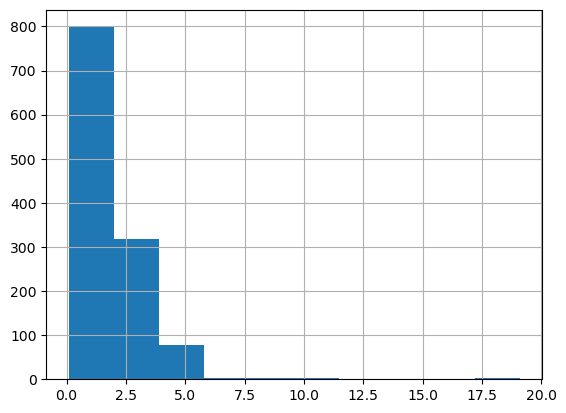

In [69]:
# everything above 27km is supposed to be meters so we need to divide by 1000

df.loc[df['central_distance'] > 27, 'central_distance'] /= 1000

df['central_distance'].hist(bins=10)

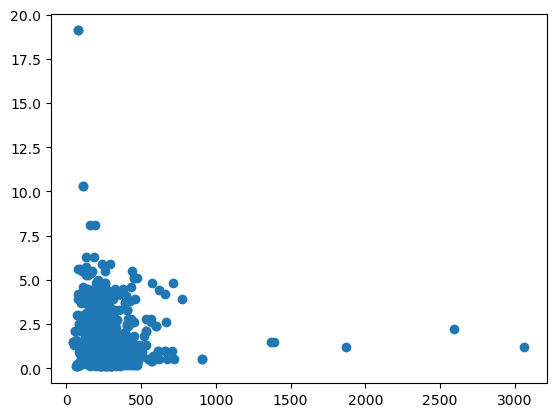

In [70]:
plt.scatter(df.price, df.central_distance)

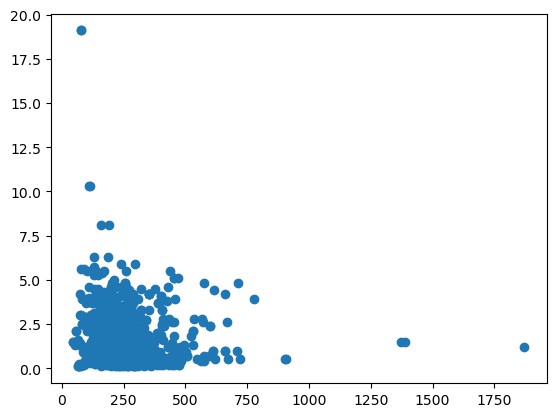

In [71]:
# we also have some outliers in the central distance column that we need to clean
# keeping majority of data just extreme outliers

df = df.loc[df.price < (df.price.mean()+(df.price.std()*10))]
plt.scatter(df.price, df.central_distance)

Cleaning the data: Removing unnecessary columns, imputing or removing NAs where necessary. We also only take those hotels that appear both in the event and non-event week.

In [72]:
df_bcn.isna().sum()

name                                       0
central_distance                           0
rating                                     7
comfort_rating                           136
review_count                               7
room_description                           0
room_specifics                            11
price                                      0
neighborhood_city                          0
start_date                                 0
end_date                                   0
map_lat                                    0
map_lng                                    0
description                                0
room_rating_personal                       7
room_rating_instalaciones y servicios     10
room_rating_limpieza                      10
room_rating_confort                       10
room_rating_relación calidad-precio       10
room_rating_ubicación                     10
room_rating_wifi gratis                   34
room_rating_10                           895
eventweek 

In [73]:
get_numeric_data = df.select_dtypes(include=[np.number]).columns

In [74]:
# drop unnecessary columns and impute na rows

print('before clean up')
print(df.shape)
print(df.shape)

df = df.drop(columns=['comfort_rating', 'room_rating_wifi gratis', 'room_rating_10'])

# impute missing numerical values
imputer = KNNImputer(n_neighbors=5)
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = pd.DataFrame(imputer.fit_transform(df[numeric_cols]), columns=numeric_cols)

# fill na strings
df['room_specifics'] = df['room_specifics'].fillna('')

# reshape dataframes so that only hotel names that are in both event and nonevent weeks are included
df_bcn = df.loc[(df.name.isin(df_intersect_bcn)) & (df.city == 1)]
#df_val = df.loc[(df.name.isin(df_intersect_val)) & (df.city == 0)]
df.loc[(df.name.isin(df_intersect_val)) & (df.city == 0)]
#df = pd.concat([df_bcn, df_val], axis=0, ignore_index=True)

# reshape dataframes so that only hotel names that are in both event and nonevent weeks are included
df_bcn = df.loc[(df.name.isin(df_intersect_bcn)) & (df.city == 1)]
df_val = df.loc[(df.name.isin(df_intersect_val)) & (df.city == 0)]
df = pd.concat([df_bcn, df_val], axis=0, ignore_index=True)

# reset index after cleanup 
df = df.reset_index()

print('after clean up')
print(df.shape)
print(df.shape)


before clean up
(1203, 27)
(1203, 27)
after clean up
(1019, 25)
(1019, 25)


/Users/andrewbennett/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/andrewbennett/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/andrewbennett/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/andrewbennett/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a fu

In [75]:
df.city.value_counts()

city
1.0    773
0.0    246
Name: count, dtype: int64

In [76]:
# create interaction term for city and week

df['cityxevt'] = df['city'] * df['eventweek']

In [77]:
# create interaction term for distance and week 

df['distance_cityevt_interaction'] = df['cityxevt'] * df['distance_evt_km']

In [78]:
df.groupby('cityxevt')['price'].mean()

cityxevt
0.0    227.107820
1.0    288.319301
Name: price, dtype: float64

In [79]:
df.cityxevt.value_counts()

cityxevt
0.0    633
1.0    386
Name: count, dtype: int64

## Event Week Regression

In [80]:

# Generate some sample data
np.random.seed(42)

X = df[['eventweek']]

y = df['price']

X_b = sm.add_constant(X)

# Create and fit the OLS (Ordinary Least Squares) model
model = sm.OLS(y, X_b)
results = model.fit()

# Print regression results summary
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     21.94
Date:                Mon, 05 Feb 2024   Prob (F-statistic):           3.19e-06
Time:                        08:46:28   Log-Likelihood:                -6388.5
No. Observations:                1019   AIC:                         1.278e+04
Df Residuals:                    1017   BIC:                         1.279e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        231.4678      5.676     40.783      0.0

## City + Event Week Regression

In [81]:

# Generate some sample data
np.random.seed(42)


X = df[['city', 'eventweek']]

y = df['price']

X_b = sm.add_constant(X)

# Create and fit the OLS (Ordinary Least Squares) model
model = sm.OLS(y, X_b)
results = model.fit()

# Print regression results summary
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     37.99
Date:                Mon, 05 Feb 2024   Prob (F-statistic):           1.23e-16
Time:                        08:46:28   Log-Likelihood:                -6362.6
No. Observations:                1019   AIC:                         1.273e+04
Df Residuals:                    1016   BIC:                         1.275e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        180.8506      8.892     20.338      0.0

## City + Event Week + City x Event Week Regression

In [82]:

# Generate some sample data
np.random.seed(42)

X = df[['city', 'eventweek', 'cityxevt']]

y = df['price']

X_b = sm.add_constant(X)

# Create and fit the OLS (Ordinary Least Squares) model
model = sm.OLS(y, X_b)
results = model.fit()

# Print regression results summary
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     25.99
Date:                Mon, 05 Feb 2024   Prob (F-statistic):           3.37e-16
Time:                        08:46:28   Log-Likelihood:                -6361.7
No. Observations:                1019   AIC:                         1.273e+04
Df Residuals:                    1015   BIC:                         1.275e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        190.5950     11.338     16.810      0.0

## City + Event Week + City x Event Week + Distance x City x Event + Rating + Review Count Regression
Testing city_event_distance interaction term

In [83]:

# Generate some sample data
np.random.seed(42)

X = X = df[['city', 'eventweek', 'cityxevt', 'distance_cityevt_interaction', 'rating', 'review_count']]

y = df['price']

X_b = sm.add_constant(X)

# Create and fit the OLS (Ordinary Least Squares) model
model = sm.OLS(y, X_b)
results = model.fit()

# Print regression results summary
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     50.30
Date:                Mon, 05 Feb 2024   Prob (F-statistic):           3.01e-54
Time:                        08:46:28   Log-Likelihood:                -6266.4
No. Observations:                1019   AIC:                         1.255e+04
Df Residuals:                    1012   BIC:                         1.258e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

The city_event_distance dummy is almost 90% significant which is interesting

## City + Event Week + City x Event Week + Distance x City x Event + Distance + Rating + Review Count Regression

Adding a control for the distance

In [84]:

# Generate some sample data
np.random.seed(42)

X = X = df[['city', 'eventweek', 'cityxevt', 'distance_cityevt_interaction', 'distance_evt_km', 'rating', 'review_count']]

y = df['price']

X_b = sm.add_constant(X)

# Create and fit the OLS (Ordinary Least Squares) model
model = sm.OLS(y, X_b)
results = model.fit()

# Print regression results summary
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     43.96
Date:                Mon, 05 Feb 2024   Prob (F-statistic):           2.17e-54
Time:                        08:46:28   Log-Likelihood:                -6264.0
No. Observations:                1019   AIC:                         1.254e+04
Df Residuals:                    1011   BIC:                         1.258e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

The city_event_distance interaction term has increased in significance after adding the control but still has multicollinearity

## NLP Analysis: Text Preprocessing

In [85]:
# combine all text fields into 1 column

df['all_text'] = df['name'] + ' ' + df['room_description'] + ' ' + df['neighborhood_city'] + ' ' + df['room_specifics'] + ' ' + df['description']

In [86]:
# create corpus
corpus = df['all_text'].tolist()

In [87]:
# define preprocessing functions for spanish text

lemmatizer = WordNetLemmatizer()

sp = spacy.load('es_core_news_sm')

def spacy_lemmatize_corpus(corpus):
    '''
        lemmatizes based on the part of speech of the word
        .pos_ to access part of speech
        .lemma_ to access the lemmatized word
    '''
    lemmatized_corpus = []
    for doc in corpus:
        sp_text = sp(doc)
        lemmatized_doc = [word.lemma_ for word in sp_text]
        lemmatized_corpus.append(" ".join(lemmatized_doc))

    return lemmatized_corpus

def remove_non_words_corpus(corpus): 
    return [' '.join(re.split(r'\W+', doc)).strip() for doc in corpus]

def lowercase_corpus_no_abbr(corpus):
    processed_corpus = []
    for doc in corpus:
        doc_arr = []
        for word in doc.split(' '):
            if re.match('([A-Z]+[a-z]*){2,}', word):
                doc_arr.append(word)
            else:
                doc_arr.append(word.lower())
        processed_corpus.append(' '.join(doc_arr))
    return processed_corpus

def remove_stop_words_corpus(corpus, language='english'):
    stop_words = set(stopwords.words(language))
    processed_corpus = []
    for doc in corpus:
        words = doc.split()
        lowered = [w for w in words if w not in stop_words]
        processed_corpus.append(' '.join(lowered))
    return processed_corpus

def stem_corpus(corpus, stem_type='porter', language=None):
    stemmer = None
    if stem_type == 'lancaster':
        stemmer = LancasterStemmer()
    elif stem_type == 'porter':
        stemmer = PorterStemmer()
    elif language is not None:
        stemmer = SnowballStemmer(language)
    
    processed_corpus = []
    for doc in corpus:
        words = doc.split()
        stemmed = [stemmer.stem(w) for w in words]
        processed_corpus.append(' '.join(stemmed))
    return processed_corpus


In [88]:
# preprocess corpus

lemmatized_corpus = spacy_lemmatize_corpus(corpus)

no_punctuation_corpus = remove_non_words_corpus(lemmatized_corpus)

lowercase_corpus = lowercase_corpus_no_abbr(no_punctuation_corpus)

no_stop_words = remove_stop_words_corpus(lowercase_corpus, language='spanish')

processed_corpus = no_stop_words.copy()

# not stemming anymore - stemmed_corpus = stem_corpus(no_stop_words, stem_type='porter')

df['processed_corpus'] = processed_corpus

## NLP Analysis: Document Vector Matrix

In [89]:
# create document term matrix

cv = CountVectorizer(ngram_range = (1,3), min_df=.1, max_df=.7)
cv.fit(processed_corpus)
vectorized_text=cv.transform(processed_corpus)
vectorized_text=vectorized_text.todense()
print("document term matrix has size", vectorized_text.shape)
print(len(cv.get_feature_names_out()))

document term matrix has size (1019, 306)
306


In [90]:
# turn the matrix into a dataframe
df_text=pd.DataFrame(vectorized_text,columns=cv.get_feature_names_out())
#analyze the dv_matrix to see the most useful n_grams
df_text.sum().sort_values(ascending=False).head(50)

hotel                         2374
metro                         1561
minuto                        1262
pie                           1217
km                            1167
valencia                      1050
minuto pie                     982
solo                           897
aeropuerto                     825
estación                       820
poder                          816
privado                        805
contar                         710
centro                         694
restaurante                    653
plaza                          645
disponer                       630
baño privado                   619
bar                            586
servicio                       586
individual                     557
situado                        554
pantalla                       549
ciudad                         543
plano                          543
pantalla plano                 543
descuento                      521
tv pantalla                    521
tv pantalla plano   

## NLP Analysis: TF-IDF Matrix

In [91]:
cv = TfidfVectorizer(ngram_range = (1,3), norm=None, min_df=.1, max_df=.8)
cv.fit(processed_corpus)
vectorized_text=cv.transform(processed_corpus)
vectorized_text=vectorized_text.todense()
print("document term matrix has size", vectorized_text.shape)

document term matrix has size (1019, 318)


In [92]:
# turn the matrix into a dataframe
df_text_idf=pd.DataFrame(vectorized_text,columns=cv.get_feature_names_out())
#analyze the df_text_idf dataframe to see the most useful n_grams
df_text_idf.sum().sort_values(ascending=False).to_csv('tfidf.csv')

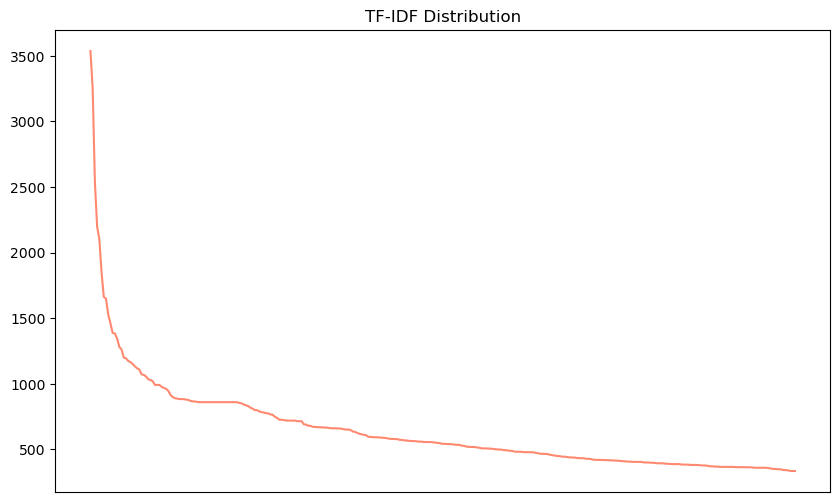

In [93]:
cool_color = '#FF5733'
ax = df_text_idf.sum().sort_values(ascending=False).plot(color='#FF5733', alpha=0.7, title='TF-IDF Distribution', figsize=(10, 6))

# Removing the x-axis
ax.xaxis.set_visible(False)

# Display the plot
plt.show()

In [94]:
top_n_grams = df_text_idf.sum().sort_values(ascending=False).index

In [95]:
df_text_idf

,10,10 minuto,10 minuto pie,15,15 minuto,15 minuto pie,20,200,200 metro,24,...,vella barcelona,vista,vistas,vía,vía satélite,wifi,wifi gratis,wifi gratis alojamiento,wifi gratuito,zona
0,0.000000,0.000000,0.000000,2.459498,2.664868,3.022283,0.0,3.007577,3.022283,0.000000,...,0.0,0.0,0.000000,0.000000,0.00000,1.256792,0.000000,0.000000,1.76214,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.984759,...,0.0,0.0,0.000000,0.000000,0.00000,1.256792,0.000000,0.000000,1.76214,0.000000
2,2.081119,2.220448,2.386294,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.984759,...,0.0,0.0,2.734601,0.000000,0.00000,1.256792,0.000000,0.000000,1.76214,4.337312
3,0.000000,0.000000,0.000000,4.918996,5.329735,6.044566,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,2.168656
4,2.081119,2.220448,2.386294,4.918996,5.329735,6.044566,0.0,0.000000,0.000000,1.984759,...,0.0,0.0,0.000000,2.162367,2.21053,1.256792,0.000000,0.000000,1.76214,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.00000,1.256792,0.000000,0.000000,1.76214,0.000000
1015,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.00000,1.256792,2.480821,3.292829,0.00000,2.168656
1016,2.081119,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.984759,...,0.0,0.0,0.000000,0.000000,0.00000,1.256792,2.480821,3.292829,0.00000,0.000000
1017,2.081119,2.220448,2.386294,0.000000,0.000000,0.000000,0.0,6.015154,6.044566,1.984759,...,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000


## NLP Analysis: TFIDF Vocab Regressions

We decide to try out the different words in regressions on price, to see if they are statistically significant. This is just another thing which we take into account when finalising the features we will use.

In [96]:
df = df.reset_index()

In [97]:
# run each of the top ngrams through a regression model and get the p-value

all_n_gram_p_vals = []

for ngram in top_n_grams:
    n_gram_stats = {}

    all_x_cols = ['city', 'eventweek', 'cityxevt']

    X = pd.concat([df[all_x_cols], df_text_idf[ngram]], axis=1)

    y = df['price']

    X_b = sm.add_constant(X)

    # Create and fit the OLS (Ordinary Least Squares) model
    model = sm.OLS(y, X_b)
    results = model.fit()

    # Print regression results summary
    # Extract the feature names and t-statistics
    summary = results.summary()
    n_gram_stats['coeff'] = float(summary.tables[1].data[:][5][1])
    n_gram_stats['p-val'] = summary.tables[1].data[:][5][4]
    n_gram_stats['ngram'] = ngram

    all_n_gram_p_vals.append(n_gram_stats)

all_n_gram_p_vals = pd.DataFrame(all_n_gram_p_vals)
all_n_gram_p_vals = all_n_gram_p_vals.sort_values(by=['p-val', 'coeff'], ascending=[True, False])

In [98]:
# view top ngrams with their coeff and p-val for analysis

all_n_gram_p_vals.head(20)
all_n_gram_p_vals.to_csv('ngram_p_vals.csv')

In [99]:
all_n_gram_p_vals

,coeff,p-val,ngram
28,-23.7091,0.000,wifi
30,-24.5404,0.000,aire acondicionado
31,-24.5404,0.000,acondicionado
229,-12.5242,0.001,estándar
17,-12.8895,0.001,estación
...,...,...,...
39,0.0876,0.986,pantalla
114,-0.0477,0.990,ducha
99,0.0232,0.995,artículo
106,-0.0221,0.995,artículo aseo


In [100]:
# turn tfidf selected features into dummies

df = pd.concat([df, df_text_idf[['wifi','aire acondicionado','recepción','metro']]], axis=1)
df.loc[df['wifi'] > 0, 'wifi'] = 1
df.loc[df['recepción'] > 0, 'recepción'] = 1
df.loc[df['aire acondicionado'] > 0, 'aire acondicionado'] = 1
df.loc[df['metro'] > 0, 'metro'] = 1
df.head()

,level_0,index,name,central_distance,rating,review_count,room_description,room_specifics,price,neighborhood_city,...,latlong,distance_evt_km,cityxevt,distance_cityevt_interaction,all_text,processed_corpus,wifi,aire acondicionado,recepción,metro
0,0,0,room mate carla,1.1,8.6,2659.0,Habitación Doble Básica,1 cama doble,248.125,"Eixample, Barcelona",...,"(41.3963185, 2.16604203)",5.162747,1.0,5.162747,room mate carla Habitación Doble Básica Eixamp...,room mate car habitación doble básica eixample...,1.0,1.296875,0.0,1.0
1,1,1,ac hotel diagonal l'illa by marriott,2.9,8.6,489.0,Habitación Estándar - Cama extragrande,1 cama doble extragrande,277.375,"Les Corts, Barcelona",...,"(41.38995401, 2.13584371)",7.781756,1.0,7.781756,ac hotel diagonal l'illa by marriott Habitació...,ac hotel diagonal l illa by marriott habitació...,1.0,0.000000,1.0,0.0
2,2,2,two hotel barcelona by axel 4* sup- adults only,1.5,8.4,2540.0,Habitación Doble - 1 o 2 camas,1 cama doble grande,234.000,"Eixample, Barcelona",...,"(41.3791458, 2.1559318)",6.764915,1.0,6.764915,two hotel barcelona by axel 4* sup- adults onl...,two hotel barcelona by axel 4 sup adults only ...,1.0,1.296875,1.0,1.0
3,3,3,hotel & spa villa olimpica suites,2.2,8.0,3424.0,Habitación Doble con acceso al spa,2 camas individuales,211.250,"Sant Martí, Barcelona",...,"(41.39712533, 2.19205141)",3.145190,1.0,3.145190,hotel & spa villa olimpica suites Habitación D...,hotel spa villa olimpico suite habitación dobl...,0.0,1.296875,0.0,1.0
4,4,4,zenit barcelona,2.1,8.2,1480.0,Habitación Doble - 1 o 2 camas,Camas: 1 doble o 2 individuales,211.125,"Sarrià-Sant Gervasi, Barcelona",...,"(41.3949201, 2.146824)",6.741776,1.0,6.741776,zenit barcelona Habitación Doble - 1 o 2 camas...,zenit barcelona habitación doble 1 2 cama sarr...,1.0,1.296875,1.0,1.0


In [104]:
# rename columns to be formatted correctly
df = df.rename(columns={'aire acondicionado': 'aire_acondicionado'})

In [105]:
# view dummies
print(df.recepción.value_counts())
print(df['wifi'].value_counts())
print(df['aire_acondicionado'].value_counts())
print(df.metro.value_counts())


recepción
0.0    620
1.0    399
Name: count, dtype: int64
wifi
1.0    788
0.0    231
Name: count, dtype: int64
aire_acondicionado
1.0    757
0.0    262
Name: count, dtype: int64
metro
1.0    677
0.0    342
Name: count, dtype: int64


## NLP Analysis: Sentiment Scores

We also try sentiment scoring, however since hotel descriptions are almost always going to be positive, while still in a professional tone, we don't expect the scores to be a good indicator for differences in hotels.

In [106]:
# Initialize HIV4
hiv4 = ps.HIV4()

# Function to get sentiment scores
def get_sentiment_scores(text):
    tokens = hiv4.tokenize(text)
    score = hiv4.get_score(tokens)
    return score


df['text_preproc'] = no_punctuation_corpus
df['sentiment_scores'] =df['all_text'].apply(get_sentiment_scores)

# Extract individual scores and create new columns
df['Positive'] = df['sentiment_scores'].apply(lambda x: x['Positive'])
df['Negative'] = df['sentiment_scores'].apply(lambda x: x['Negative'])
df['Polarity'] = df['sentiment_scores'].apply(lambda x: x['Polarity'])
df['Subjectivity'] = df['sentiment_scores'].apply(lambda x: x['Subjectivity'])

# Add text length
df['TextLength'] = df['text_preproc'].apply(len)

# Calculate the score for each article
df['SentimentScore'] = ((df['Positive'] - df['Negative']) / df['TextLength'])

# Find the article with the highest score
most_positive_article = df.loc[df['SentimentScore'].idxmax()]

# Find the article with the lowest score
most_negative_article = df.loc[df['SentimentScore'].idxmin()]

# Print the most positive article
print("Most Positive Article:")
print("Score:", most_positive_article['SentimentScore'])
print("Text:", most_positive_article['all_text'])
print("\n")

# Print the most negative article
print("Most Negative Article:")
print("Score:", most_negative_article['SentimentScore'])
print("Text:", most_negative_article['all_text'])



Most Positive Article:
Score: 0.010752688172043012
Text: pensión alicante Habitación Estándar con baño compartido - 2 camas Ciutat Vella, Valencia 2 camas individuales 




¡Puedes conseguir un descuento Genius en Pensión Alicante! Para ahorrar en este alojamiento, solo tienes que iniciar sesión.
Pensión Alicante is located in central Valencia, just 3 minutes’ walk from Esctació del Nord Station. It offers rooms with free WiFi, a TV and a shower in the room.

Pensión Alicante does not have a physical reception, all the doors of the guesthouse are opened with electronic keys through the mobile application called "Danalock". A few days before your arrival you will receive a link and detailed instructions for online check-in and door access. Staff can provide information about what to see and do in Valencia.

The guest house is 10 minutes’ walk from the Lonja de la Seda, Valencia’s medieval market and now a UNESCO World Heritage Site. Xàtiva Metro Station is 3 minutes’ walk away, connecti

there does not seem to be much variation in the documents, but we can try a regression with it anyways

## NLP Analysis: Regression with Sentiment Scoring

In [107]:

# Generate some sample data
np.random.seed(42)

X = df[['city', 'eventweek', 'cityxevt', 'SentimentScore']]

y = df['price']

X_b = sm.add_constant(X)

# Create and fit the OLS (Ordinary Least Squares) model
model = sm.OLS(y, X_b)
results = model.fit()

# Print regression results summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     23.71
Date:                Mon, 05 Feb 2024   Prob (F-statistic):           9.07e-19
Time:                        08:49:11   Log-Likelihood:                -6353.8
No. Observations:                1019   AIC:                         1.272e+04
Df Residuals:                    1014   BIC:                         1.274e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            175.5113     11.881     14.

somewhat significant, lets add in the other variables

## NLP Analysis: Full Regression with Sentiment

In [109]:

# Generate some sample data
np.random.seed(42)

X = df[['city', 'eventweek', 'cityxevt', 'is_major_brand', 'wifi','aire_acondicionado','recepción','metro', 'room_rating_personal', 'room_rating_instalaciones y servicios', 'rating']]

y = df['price']

X_b = sm.add_constant(X)

# Create and fit the OLS (Ordinary Least Squares) model
model = sm.OLS(y, X_b)
results = model.fit()

# Print regression results summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.249
Method:                 Least Squares   F-statistic:                     31.74
Date:                Mon, 05 Feb 2024   Prob (F-statistic):           5.33e-58
Time:                        08:49:30   Log-Likelihood:                -6247.7
No. Observations:                1019   AIC:                         1.252e+04
Df Residuals:                    1007   BIC:                         1.258e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

## Summary outputs and formatted tables for LaTex

In [110]:
# summary value counts

nlp_features = ['is_major_brand', 'wifi','aire_acondicionado','recepción','metro']

desc = df[nlp_features].describe().round(2).astype(str)


counts_city_feature_one = []

for i in nlp_features:
    count = df[df['city'] == 1].groupby('city')[i].value_counts().get((1.0, 1.0), 0)
    counts_city_feature_one.append(count)

print(counts_city_feature_one)

value_counts_ones = []

for i in nlp_features:
    count_ones = (df[i] == 1).sum()
    value_counts_ones.append(count_ones)

print(value_counts_ones)

[134, 566, 566, 322, 589]
[183, 788, 757, 399, 677]


In [111]:
df.groupby(['city','eventweek'])['price'].mean()

city  eventweek
0.0   0.0          190.595041
      1.0          209.389000
1.0   0.0          244.247093
      1.0          288.319301
Name: price, dtype: float64

In [112]:
# mean prices when feature is 0 and 1

mean_prices_zero = []
mean_prices_one = []

for i in nlp_features:
    grouped_mean = df.groupby(i)['price'].mean()
    mean_prices_zero.append(grouped_mean.get(0, 0).round(2).astype(str))
    mean_prices_one.append(grouped_mean.get(1, 0).round(2).astype(str))

print("Mean Prices when feature is 0:", mean_prices_zero)
print("Mean Prices when feature is 1:", mean_prices_one)


Mean Prices when feature is 0: ['247.51', '284.95', '277.87', '256.72', '245.96']
Mean Prices when feature is 1: ['263.03', '240.14', '240.75', '240.3', '252.49']


In [113]:
# create summary table
desc = desc.transpose()
desc['value_count_ones'] = value_counts_ones
desc['value_count_Bcn'] = counts_city_feature_one
desc['mean_price_0'] = mean_prices_zero
desc['mean_price_1'] = mean_prices_one
desc = desc.drop(columns=['std', 'min', '25%', '50%', '75%', 'max'])
print(desc.to_latex())

\begin{tabular}{lllrrll}
\toprule
 & count & mean & value_count_ones & value_count_Bcn & mean_price_0 & mean_price_1 \\
\midrule
is_major_brand & 1019.0 & 0.18 & 183 & 134 & 247.51 & 263.03 \\
wifi & 1019.0 & 0.77 & 788 & 566 & 284.95 & 240.14 \\
aire_acondicionado & 1019.0 & 0.74 & 757 & 566 & 277.87 & 240.75 \\
recepción & 1019.0 & 0.39 & 399 & 322 & 256.72 & 240.3 \\
metro & 1019.0 & 0.66 & 677 & 589 & 245.96 & 252.49 \\
\bottomrule
\end{tabular}



In [116]:
# create regression summary table

reg1 = sm.OLS(endog=df['price'], exog=sm.add_constant(df['eventweek'])).fit()
reg2 = sm.OLS(endog=df['price'], exog=sm.add_constant(df['city'])).fit()
reg3 = sm.OLS(endog=df['price'], exog=sm.add_constant(df[['city', 'eventweek', 'cityxevt']])).fit()
reg4 = sm.OLS(endog=df['price'], exog=sm.add_constant(df[['city', 'eventweek', 'cityxevt', 'is_major_brand', 'wifi','aire_acondicionado','recepción','metro', 
                                                           'room_rating_instalaciones y servicios', 'rating']])).fit()

stargazer = Stargazer([reg3, reg4])
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{1}{c}{\textit{Dependent variable: price}} \
\cr \cline{2-2}
\\[-1.8ex] & (1) \\
\hline \\[-1.8ex]
 city & 53.652$^{***}$ \\
& (12.990) \\
 cityxevt & 25.278$^{}$ \\
& (18.262) \\
 const & 190.595$^{***}$ \\
& (11.338) \\
 eventweek & 18.794$^{}$ \\
& (15.906) \\
\hline \\[-1.8ex]
 Observations & 1019 \\
 $R^2$ & 0.071 \\
 Adjusted $R^2$ & 0.069 \\
 Residual Std. Error & 124.720 (df=1015) \\
 F Statistic & 25.987$^{***}$ (df=3; 1015) \\
\hline
\hline \\[-1.8ex]
\textit{Note:} & \multicolumn{1}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\
\end{tabular}
\end{table}


In [117]:
# regression summary table
stargazer = Stargazer([reg1, reg2, reg3])
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{3}{c}{\textit{Dependent variable: price}} \
\cr \cline{2-4}
\\[-1.8ex] & (1) & (2) & (3) \\
\hline \\[-1.8ex]
 city & & 66.110$^{***}$ & 53.652$^{***}$ \\
& & (9.235) & (12.990) \\
 cityxevt & & & 25.278$^{}$ \\
& & & (18.262) \\
 const & 231.468$^{***}$ & 200.145$^{***}$ & 190.595$^{***}$ \\
& (5.676) & (8.043) & (11.338) \\
 eventweek & 37.544$^{***}$ & & 18.794$^{}$ \\
& (8.015) & & (15.906) \\
\hline \\[-1.8ex]
 Observations & 1019 & 1019 & 1019 \\
 $R^2$ & 0.021 & 0.048 & 0.071 \\
 Adjusted $R^2$ & 0.020 & 0.047 & 0.069 \\
 Residual Std. Error & 127.921 (df=1017) & 126.154 (df=1017) & 124.720 (df=1015) \\
 F Statistic & 21.943$^{***}$ (df=1; 1017) & 51.247$^{***}$ (df=1; 1017) & 25.987$^{***}$ (df=3; 1015) \\
\hline
\hline \\[-1.8ex]
\textit{Note:} & \multicolumn{3}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\
\end{tabular}
\end{table}
